# Diamond Pricing Models
## Authored by Trinity Gahagen
### Phase 3 Project for Flatiron School
---
---

## Objective
This notebook will work off of the previous findings of the analysis notebook in order to create and train a machine learning model. The original goal was to create a regression model that could capture the variance in the data and predict the price of a diamond based on features passed into the model. However, this proved to be very challenging, and so the final model will be a classifier instead of a regressor.

## Introduction
---
Based on the findings of the analysis notebook, the distribution of prices of diamonds in this dataset are highly right skewed, so applying a log-transformation on this column may be appropriate. Carats are highly correlated with price, and will most definitely be included as a feature in the training/testing data.

It is still unclear whether or not all of the other columns have a strong correlation with price, but we at the very least know that the higher the grade of clarity the diamond has, the higher it tends to cost. So the final features will most definitely include carats and clarity.

In [66]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 13
from matplotlib.ticker import FuncFormatter

# ML Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, make_scorer
# Regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

# ML Models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor

In [2]:
# Read in the final dataset from the end of the analysis notebook
diamonds = pd.read_csv('updated_diamonds.csv')

In [3]:
# Check which columns are included
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   shape       119307 non-null  object 
 1   price       119307 non-null  int64  
 2   carat       119307 non-null  float64
 3   cut         119307 non-null  object 
 4   color       119307 non-null  object 
 5   clarity     119307 non-null  object 
 6   report      119307 non-null  object 
 7   type        119307 non-null  object 
 8   sqrt_price  119307 non-null  float64
 9   log_price   119307 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 9.1+ MB


## Data Cleaning/Preprocessing

Scikit-Learn is not compatible with string type data, so we will need to convert all of the "object" columns to integers or floats.

Because there are both nominal (shape, report) and ordinal (clarity, cut, color) columns, we will encode the nominal columns with one-hot encoding to prevent any kind of accidental numerical relationship among the categories, the ordinal columns will be label encoded to reflect the natural hierarchy of the grading labels.

In [4]:
# Choose the columns to one-hot encode
one_hot_columns = ['shape', 'report']

preprocessed_diamonds = pd.get_dummies(diamonds, columns=one_hot_columns, drop_first=True, dtype=int)
preprocessed_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  object 
 3   color           119307 non-null  object 
 4   clarity         119307 non-null  object 
 5   type            119307 non-null  object 
 6   sqrt_price      119307 non-null  float64
 7   log_price       119307 non-null  float64
 8   shape_Cushion   119307 non-null  int32  
 9   shape_Emerald   119307 non-null  int32  
 10  shape_Heart     119307 non-null  int32  
 11  shape_Marquise  119307 non-null  int32  
 12  shape_Oval      119307 non-null  int32  
 13  shape_Pear      119307 non-null  int32  
 14  shape_Princess  119307 non-null  int32  
 15  shape_Radiant   119307 non-null  int32  
 16  shape_Round     119307 non-null  int32  
 17  report_GIA

In [5]:
# Remind myself of what unique categories are in the ordinal columns
for col in ['cut', 'color', 'clarity']:
    print(diamonds[col].unique())

['Very Good' 'Ideal' 'Super Ideal' 'Good' 'Fair']
['J' 'I' 'E' 'F' 'G' 'H' 'D']
['SI2' 'SI1' 'VS2' 'VVS1' 'VS1' 'VVS2' 'IF' 'FL']


In [6]:
# Label encoding for the categories with inherent order
# The higher the grade, the larger the integer
cut_encoder = {
    'Fair' : 0,
    'Good' : 1,
    'Very Good' : 2,
    'Ideal' : 3,
    'Super Ideal': 4
}

color_encoder = {
    'J' : 0,
    'I' : 1,
    'H' : 2,
    'G' : 3,
    'F' : 4,
    'E' : 5,
    'D' : 6,
}

clarity_encoder = {
    'SI2' : 0,
    'SI1' : 1,
    'VS2' : 2,
    'VS1' : 3,
    'VVS2' : 4,
    'VVS1' : 5,
    'IF' : 6,
    'FL' : 7
}

In [7]:
# Update columns with their labels
preprocessed_diamonds['cut'] = preprocessed_diamonds['cut'].map(cut_encoder)

preprocessed_diamonds['color'] = preprocessed_diamonds['color'].map(color_encoder)

preprocessed_diamonds['clarity'] = preprocessed_diamonds['clarity'].map(clarity_encoder)

In [8]:
# Binarizing the type column
type_encoder = {
    'natural' : 1,
    'lab' : 0
}

In [9]:
# Update the type column to be a "natural" flag instead of two separate columns
preprocessed_diamonds['natural'] = preprocessed_diamonds['type'].map(type_encoder)

preprocessed_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  int64  
 3   color           119307 non-null  int64  
 4   clarity         119307 non-null  int64  
 5   type            119307 non-null  object 
 6   sqrt_price      119307 non-null  float64
 7   log_price       119307 non-null  float64
 8   shape_Cushion   119307 non-null  int32  
 9   shape_Emerald   119307 non-null  int32  
 10  shape_Heart     119307 non-null  int32  
 11  shape_Marquise  119307 non-null  int32  
 12  shape_Oval      119307 non-null  int32  
 13  shape_Pear      119307 non-null  int32  
 14  shape_Princess  119307 non-null  int32  
 15  shape_Radiant   119307 non-null  int32  
 16  shape_Round     119307 non-null  int32  
 17  report_GIA

In [10]:
try:
    preprocessed_diamonds.drop(columns='type', inplace=True)
except:
    print("Column already dropped")

## "Shotgun" Approach: Regression

In this section, we will be using several base classifiers to start with and seeing how well the perform on the dataset without any kind of parameter tuning. The scoring metric we will use is the default scoring metric of regression models, $R^2$.

In [11]:
# Create a dictionary of initialized regression models and empty score lists
initial_models = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [12]:
# Split data into features and target, starting with the un-transformed price column
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['price']

In [13]:
# Iterate through each model in the dictionary and cross validate to measure performance
for model in initial_models:
    kfold = KFold(n_splits=10)
    regressor = initial_models[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

In [14]:
for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -250.95707663407953
----------------------------------------
Model Name: ridge
Average R^2 Score: -251.95242674416608
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -2.5823091249090093
----------------------------------------
Model Name: ada
Average R^2 Score: -740.8403418296868
----------------------------------------
Model Name: gboost
Average R^2 Score: -6.313926466889188
----------------------------------------
Model Name: knn
Average R^2 Score: -7.8380752200192045
----------------------------------------


All of the base estimators did terribly predicting the values of the un-transformed target variable, price. Will the model do better if we apply a square root transformation on the target variable?

In [15]:
# Split data into features and target, now with square root transform
# X is the same as before
y = preprocessed_diamonds['sqrt_price']

initial_models_sqrt = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [16]:
for model in initial_models_sqrt:
    kfold = KFold(n_splits=10)
    regressor = initial_models_sqrt[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_sqrt[model]['score'].extend(results)

In [17]:
for model in initial_models_sqrt:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_sqrt[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -6.7223281993808275
----------------------------------------
Model Name: ridge
Average R^2 Score: -9.100679697885258
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.683967611509091
----------------------------------------
Model Name: ada
Average R^2 Score: -63.97501660555851
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.9643987456025199
----------------------------------------
Model Name: knn
Average R^2 Score: -4.518743036559828
----------------------------------------


The models overall did a bit better at predicting the target variable after it's been transformed, but all of them still do terribly (since the $R^2$ values are all negative). The model doing the best so far is the Gradient Boosting Regressor.

What if we transform the data again, this time with a log transformation to account for skewness?

In [18]:
# Split data into features and target, now with log transform
# X is still the same
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [19]:
for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

In [20]:
for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.994353639211267
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3395150451754692
----------------------------------------
Model Name: ada
Average R^2 Score: -5.534778744406107
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781200447564945
----------------------------------------
Model Name: knn
Average R^2 Score: -3.676155934675672
----------------------------------------


Most models did better with the log transformed target than they did with the square root transformed data, but the $R^2$ scores are all still negative, indicating that the model did much worse with predicting on the testing data than the training data.

Before giving up on regression, I will remove the outliers to see if that will affect the models, since large values are severely skewing the dataset.

In [21]:
# Create a copy of the dataset that excludes outliers on the basis of Z-Score removal
no_outliers = preprocessed_diamonds.copy()
no_outliers['zscore_price'] = (no_outliers['price'] - no_outliers['price'].mean()) / no_outliers['price'].std()
OUTLIERS = no_outliers['zscore_price'] > 3.5

# Rinse and repeat the process from the previous cells
X = no_outliers.loc[~OUTLIERS].drop(columns=['price', 'sqrt_price', 'log_price', 'zscore_price'])
y = no_outliers.loc[~OUTLIERS, 'log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.183705927754232
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.41324503681785
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3876072764440885
----------------------------------------
Model Name: ada
Average R^2 Score: -5.261302670402683
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.7333063938618082
----------------------------------------
Model Name: knn
Average R^2 Score: -3.74068971724384
----------------------------------------


In [22]:
# Remove outliers based on the scatterplot visualizations of the previous notebook
OUTLIERS = no_outliers['carat'] > 5

X = no_outliers.loc[~OUTLIERS].drop(columns=['price', 'sqrt_price', 'log_price', 'zscore_price'])
y = no_outliers.loc[~OUTLIERS, 'log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.367862690519527
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.34412947938272
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3595381155840456
----------------------------------------
Model Name: ada
Average R^2 Score: -5.163484842081479
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6863557790179274
----------------------------------------
Model Name: knn
Average R^2 Score: -3.7039741757624016
----------------------------------------


Removing outliers based on price OR carats does not improve any of the models' $R^2$ scoring metric in any way. I think that I'll just start using the Gradient Boosting Regressor, since it had the only $R^2$ value that was even close to being positive.

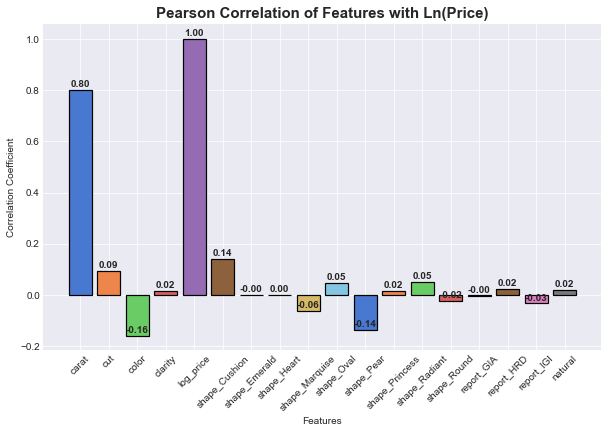

In [23]:
# Calculate the correlation of the features with the natural log of the price column
correlations = preprocessed_diamonds.drop(columns=['sqrt_price', 'price']).corr()['log_price']

# Plot the correlations
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x=correlations.index, height=correlations, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i in correlations.index:
    ax.annotate(f'{correlations[i]:.02f}',
                xy=(i, correlations[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Features')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Pearson Correlation of Features with Ln(Price)');

In [24]:
# Select features that have an absolute value of greater than or equal to 0.05
selected_features = [feature for feature in correlations.index if (np.abs(correlations[feature]) >= 0.05) & (correlations[feature] < 1)]
selected_features

['carat',
 'cut',
 'color',
 'shape_Cushion',
 'shape_Marquise',
 'shape_Pear',
 'shape_Radiant']

In [25]:
# Rinse and repeat, this time with the new features
X = preprocessed_diamonds[selected_features]
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -6.285252883926916
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -9.528738614924164
----------------------------------------
Model Name: ada
Average R^2 Score: -7.6649287279322476
----------------------------------------
Model Name: gboost
Average R^2 Score: -7.356571992767265
----------------------------------------
Model Name: knn
Average R^2 Score: -10.729799714922363
----------------------------------------


Feature selection definitely did not help.

What about scaling the data?

In [26]:
# Using Min-Max Scaler
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)

    pipeline = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('regressor', initial_models_log[model]['model'])
    ])
    
    results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -6.041466643456806
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3336759971879155
----------------------------------------
Model Name: ada
Average R^2 Score: -5.408482734364304
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781579053211734
----------------------------------------
Model Name: knn
Average R^2 Score: -4.654354747735066
----------------------------------------


In [27]:
# Using Standard Scaler
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', initial_models_log[model]['model'])
    ])
    
    results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.99432024735452
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3354281850839933
----------------------------------------
Model Name: ada
Average R^2 Score: -6.127624839305417
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781168121591558
----------------------------------------
Model Name: knn
Average R^2 Score: -2.8465922806167936
----------------------------------------


Neither scaling techniques, Standard Scaling nor Min-Max Scaling, seemed to have any effect. What if we change up the target variable one more time?

In [28]:
# Create a column that expresses the price in terms of carats
preprocessed_diamonds['price_per_carat'] = preprocessed_diamonds['price'] / preprocessed_diamonds['carat']
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price', 'carat', 'price_per_carat'])
y = preprocessed_diamonds['price_per_carat']

initial_models = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models:
    kfold = KFold(n_splits=10)

    # pipeline = Pipeline(steps=[
    #     ('scaler', StandardScaler()),
    #     ('regressor', initial_models[model]['model'])
    # ])
    
    regressor = initial_models[model]['model']

    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -12.500595303335615
----------------------------------------
Model Name: ridge
Average R^2 Score: -12.418462239483171
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -15.765859181336051
----------------------------------------
Model Name: ada
Average R^2 Score: -24.815103104916822
----------------------------------------
Model Name: gboost
Average R^2 Score: -13.895212767632154
----------------------------------------
Model Name: knn
Average R^2 Score: -20.74192133205866
----------------------------------------


Regression seems to produce only futile results. No matter what model I use, what transformations, features, or even outlier removal methods I include, I can't break even a 0 $R^2$ value. I'm going to pivot to Classification instead.

## "Shotgun" Approach: Classification
---


Before starting the classification approach, we must first get rid of the columns that were oriented towards a regression approach.

In [67]:
try:
    preprocessed_diamonds.drop(columns=['sqrt_price', 'log_price', 'price_per_carat'], inplace=True)
except:
    print("Already dropped")

preprocessed_diamonds.info()

Already dropped
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  int64  
 3   color           119307 non-null  int64  
 4   clarity         119307 non-null  int64  
 5   shape_Cushion   119307 non-null  int32  
 6   shape_Emerald   119307 non-null  int32  
 7   shape_Heart     119307 non-null  int32  
 8   shape_Marquise  119307 non-null  int32  
 9   shape_Oval      119307 non-null  int32  
 10  shape_Pear      119307 non-null  int32  
 11  shape_Princess  119307 non-null  int32  
 12  shape_Radiant   119307 non-null  int32  
 13  shape_Round     119307 non-null  int32  
 14  report_GIA      119307 non-null  int32  
 15  report_HRD      119307 non-null  int32  
 16  report_IGI      119307 non-null  int32  

Now, we can create a column that classifies diamonds based on a price criterion.

In [30]:
# Look at the spread of data to determine where the thresholds will be for each class
preprocessed_diamonds['price'].describe()

count    1.193070e+05
mean     3.286843e+03
std      9.114695e+03
min      2.700000e+02
25%      9.000000e+02
50%      1.770000e+03
75%      3.490000e+03
max      1.348720e+06
Name: price, dtype: float64

In [68]:
# Define a function that will assign classes based on price
def price_classifier(price):
    """
    Creates classes based off of the following criteria:
    0 - Affordable
    1 - Moderately Affordable
    2 - Moderately Expensive
    3 - Expensive
    4 - Very Expensive
    """
    if 0 < price < 1000:
        return 0
    elif 1000 <= price < 3000:
        return 1
    elif 3000 <= price < 7000:
        return 2
    elif 7000 <= price < 15000:
        return 3
    else:
        return 4

In [69]:
# Create a column based on the mapper function from the cell above
preprocessed_diamonds['price_point'] = preprocessed_diamonds['price'].map(price_classifier)

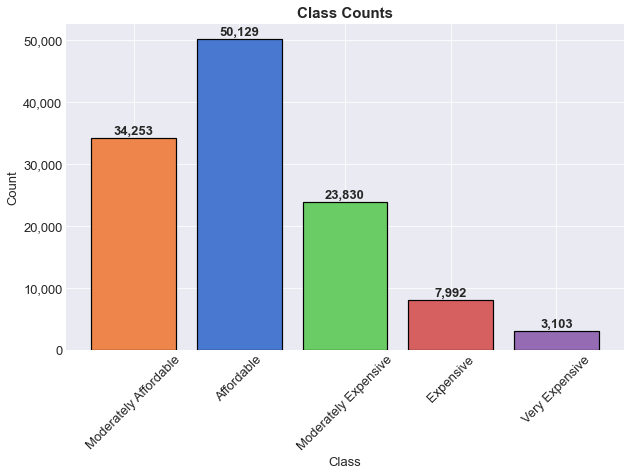

In [70]:
# Plot the number of observations in each class
fig, ax = plt.subplots(figsize=(10, 6))
class_counts = preprocessed_diamonds['price_point'].value_counts()
labels = ['Affordable', 'Moderately Affordable', 'Moderately Expensive', 'Expensive', 'Very Expensive']

ax.bar(x=class_counts.index, height=class_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i in class_counts.index:
    ax.annotate(f'{class_counts[i]:,.0f}',
                xy=(i, class_counts[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
ax.set_xticks(class_counts.index, labels=labels)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Counts');

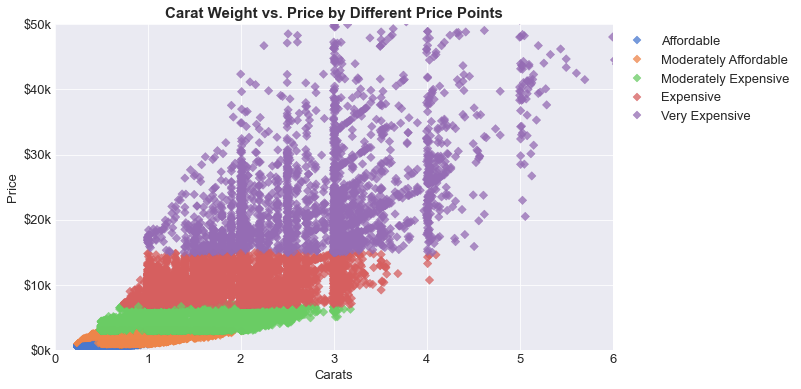

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=preprocessed_diamonds,
                x='carat', y='price',
                edgecolor=None,
                hue='price_point',
                ax=ax, palette='muted',
                marker='D',
                alpha=0.75)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y * 1e-3:.0f}k'))
ax.set_title('Carat Weight vs. Price by Different Price Points')
ax.set_xlabel('Carats')
ax.set_ylabel('Price')
ax.set_ylim(0, 50000)
ax.set_xlim(0, 6)

handles, old_labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

The counts for each class show that there is definitely an imbalance. This is worth keeping in mind for later when tuning models.

In [35]:
# Remind myself what columns are now in the dataset
preprocessed_diamonds.columns

Index(['price', 'carat', 'cut', 'color', 'clarity', 'shape_Cushion',
       'shape_Emerald', 'shape_Heart', 'shape_Marquise', 'shape_Oval',
       'shape_Pear', 'shape_Princess', 'shape_Radiant', 'shape_Round',
       'report_GIA', 'report_HRD', 'report_IGI', 'natural', 'price_point'],
      dtype='object')

In [36]:
# Create new feature and target variables for the sake of classification
X = preprocessed_diamonds.drop(columns=['price', 'price_point'])
y = preprocessed_diamonds['price_point']

In [37]:
# Rinse and repeat with classification models instead of regression models
initial_models = {
    'logreg' : {
        'model' : LogisticRegression(),
        'score' : []
    },
    'dt' : {
        'model' : DecisionTreeClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostClassifier(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsClassifier(),
        'score' : []
    },
    'svm' : {
        'model' : SVC(),
        'score' : []
    }
}

for model in initial_models:
    kfold = StratifiedKFold(n_splits=10)
    regressor = initial_models[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

In [38]:
for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average Accuracy Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: logreg
Average Accuracy Score: 0.7930383625938557
----------------------------------------
Model Name: dt
Average Accuracy Score: 0.8281902709228526
----------------------------------------
Model Name: rand_forest
Average Accuracy Score: 0.8324910025044115
----------------------------------------
Model Name: ada
Average Accuracy Score: 0.6036872831859471
----------------------------------------
Model Name: gboost
Average Accuracy Score: 0.8148648750994383
----------------------------------------
Model Name: knn
Average Accuracy Score: 0.7832068038890567
----------------------------------------
Model Name: svm
Average Accuracy Score: 0.82965816788248
----------------------------------------


These scores are much better than the previous regression metric scores.

The best model here from just an initial look at the average accuracy score is the Random Forest Classifier.

## Tuning

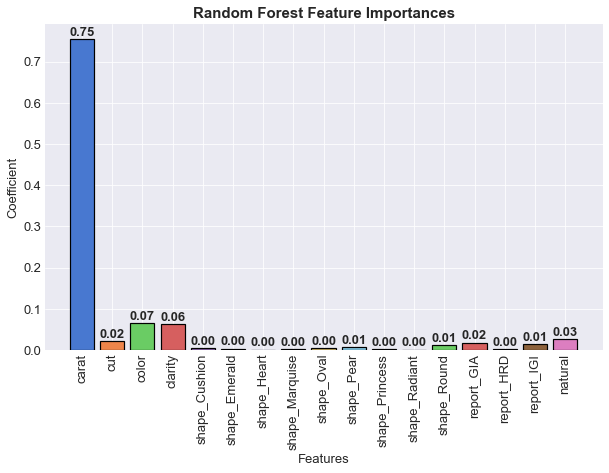

In [85]:
# Look at feature importances to see which ones we can eliminate from feature data
X = preprocessed_diamonds.drop(columns=['price', 'price_point'])
y = preprocessed_diamonds['price_point']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


rand_forest = RandomForestClassifier()

rand_forest.fit(X_train, y_train)

feature_importances = rand_forest.feature_importances_
feature_names = X.columns
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x=feature_names, height=feature_importances, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i, name in enumerate(feature_names):
    ax.annotate(f'{feature_importances[i]:.02f}',
                xy=(i, feature_importances[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient')
ax.set_title('Random Forest Feature Importances');


In [86]:
y_pred = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6851
           1       0.94      0.94      0.94     10026
           2       0.92      0.92      0.92      4766
           3       0.88      0.89      0.89      1598
           4       0.95      0.89      0.92       621

    accuracy                           0.93     23862
   macro avg       0.93      0.92      0.92     23862
weighted avg       0.93      0.93      0.93     23862



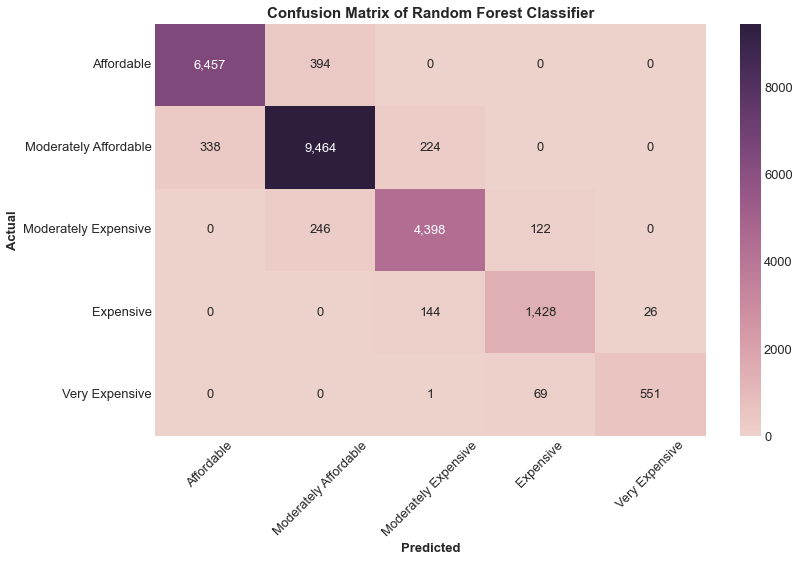

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax, fmt=',d')
ax.set_title('Confusion Matrix of Random Forest Classifier')
ax.set_xlabel('Predicted', weight='bold')
ax.set_ylabel('Actual', weight='bold')
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels=labels)
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], labels=labels)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)
plt.tight_layout();

In [42]:
kfold = StratifiedKFold(n_splits=10)
rand_forest = RandomForestClassifier()

results = cross_val_score(rand_forest, X, y, cv=kfold, n_jobs=-1)

In [43]:
print(f'Average accuracy score: {np.mean(results)}')

Average accuracy score: 0.8319629339785072


To cut down on the number of features used in the model, we will only use the features with importances greater than 0.01.

In [44]:
features = ['carat', 'cut', 'color', 'clarity', 'natural', 'report_GIA']

Will scaling have an effect now?

In [45]:
# Create new feature/target variables using the columns from above
X = preprocessed_diamonds[features]
y = preprocessed_diamonds['price_point']

# Create a Pipeline that scales the data before fitting it to the model
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('rand_forest', RandomForestClassifier())
]
)

# Cross validate
kfold = StratifiedKFold(n_splits=10)

results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1, scoring='accuracy')

In [46]:
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.8201784520562949


In [47]:
# Scale using Standard Scaler instead of Min-Max
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rand_forest', RandomForestClassifier())
]
)

kfold = StratifiedKFold(n_splits=10)

results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1, scoring='accuracy')

In [48]:
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.819776116272928


In [49]:
# No scaling
results = cross_val_score(RandomForestClassifier(), X, y, cv=kfold, n_jobs=-1, scoring='accuracy')
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.819231338789827


Scaling seems to only produce a negligible difference in the average accuracy score of the model. Therefore, we will not be scaling our data.

In [50]:
# Randomly search for the optimal values of 
param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [100, 150, 200, 300, 400, 500, 600, 700, 1000],
    'min_samples_split' : [2, 5, 10, 15, 20, 25],
    'min_samples_leaf' : [1, 2, 5, 10, 15]
}

kfold = StratifiedKFold(n_splits=10)
rand_forest = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rand_forest,
                                   param_distributions=param_grid,
                                   cv=kfold,
                                   n_iter=6,
                                   n_jobs=-1,
                                   scoring='accuracy',
                                   random_state=10)

In [51]:
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=6, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [100, 150, 200, 300, 400,
                                                      500, 600, 700, 1000],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300, 350, 400,
                                                         450, 500]},
                   random_state=10, scoring='accuracy')

In [52]:
best_estimator = random_search.best_estimator_
best_estimator

RandomForestClassifier(criterion='log_loss', max_depth=400,
                       min_samples_split=15, n_estimators=10)

In [53]:
random_search.best_score_

0.8278309598436329

Using Random Search Cross validation, we found the optimal hyperparameter value combinations from randomly sampled parameters. It may not be the best out of all possible combinations, but it's optimal for what was chosen.

Now, we will try and address the class imbalance in the target values.

In [54]:
# Trying to rebalance the classes using SMOTE
# First, by oversampling the minority classes
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')
model = best_estimator

steps = [('over', over), ('under', under), ('model', model)]

pipeline = imb_pipe(steps=steps)

In [55]:
# Evaluate pipeline
cv = StratifiedKFold(n_splits=10)

scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [56]:
print(f'Average Accuracy Score: {np.mean(scores)}')

Average Accuracy Score: 0.8220391581012446


The following few code blocks were just to verify that SMOTE was doing what I think it was doing, which was sampling the minority classes to balance with the majority.

In [57]:
X_plot = preprocessed_diamonds[['carat', 'price']]
y_plot = preprocessed_diamonds['price_point']

y_plot.value_counts()

price_point
1    50129
0    34253
2    23830
3     7992
4     3103
Name: count, dtype: int64

In [58]:
over = SMOTE(sampling_strategy='auto')

steps = [('over', over)]

test_pipe = imb_pipe(steps=steps)

X_resamp, y_resamp = test_pipe.fit_resample(X_plot, y_plot)

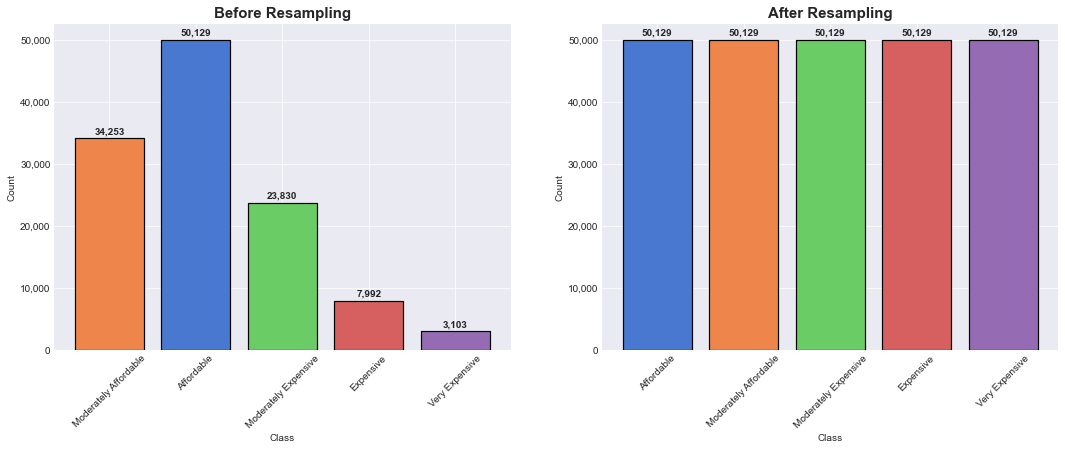

In [59]:
before_resamp = y_plot
after_resamp = y_resamp

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for n, data in enumerate([before_resamp, after_resamp]):
    ax = axes[n]
    class_counts = data.value_counts()
    labels = ['Affordable', 'Moderately Affordable', 'Moderately Expensive', 'Expensive', 'Very Expensive']

    ax.bar(x=class_counts.index, height=class_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
    for i in class_counts.index:
        ax.annotate(f'{class_counts[i]:,.0f}',
                    xy=(i, class_counts[i] + (0.02 * ax.get_ylim()[1])),
                    fontweight='bold',
                    va='center',
                    ha='center')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
    ax.set_xticks(class_counts.index, labels=labels)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

axes[0].set_title('Before Resampling')
axes[1].set_title('After Resampling');
# sns.scatterplot(data=X_plot, x='carat', y='price', hue=y_plot, marker='D', alpha=0.5, edgecolor=None, ax=ax[0])
# sns.scatterplot(data=X_resamp, x='carat', y='price', hue=y_resamp, marker='D', alpha=0.5, edgecolor=None, ax=ax[1])

In [60]:
X = preprocessed_diamonds[features]
y = preprocessed_diamonds['price_point']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

over = SMOTE(sampling_strategy='auto')
model = RandomForestClassifier(criterion='log_loss', max_depth=400, min_samples_split=15, n_estimators=10)

steps = [('over', over), ('model', model)]

pipeline = imb_pipe(steps=steps)

In [61]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6851
           1       0.94      0.90      0.92     10026
           2       0.88      0.89      0.89      4766
           3       0.79      0.87      0.83      1598
           4       0.86      0.91      0.88       621

    accuracy                           0.91     23862
   macro avg       0.88      0.90      0.89     23862
weighted avg       0.91      0.91      0.91     23862



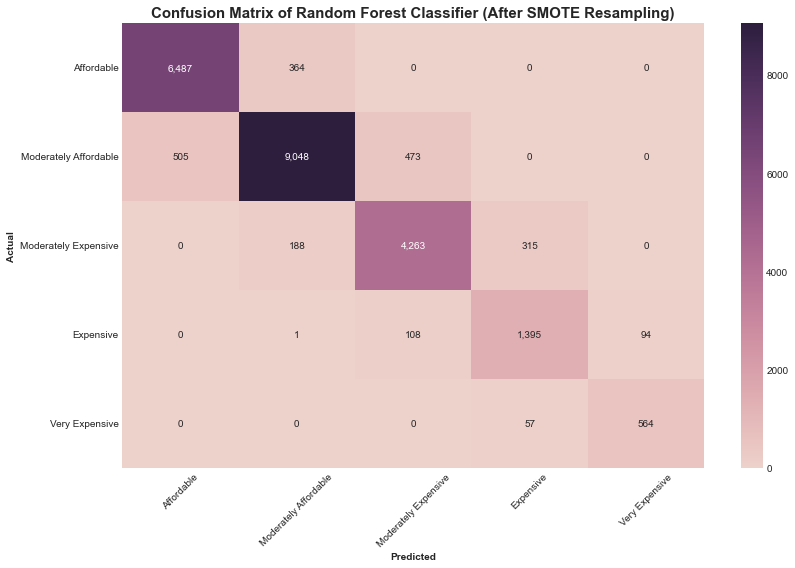

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax, fmt=',d')
ax.set_title('Confusion Matrix of Random Forest Classifier (After SMOTE Resampling)')
ax.set_xlabel('Predicted', weight='bold')
ax.set_ylabel('Actual', weight='bold')
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], labels=labels)
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], labels=labels)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)
plt.tight_layout();

In [64]:
X = preprocessed_diamonds[features]
y = preprocessed_diamonds['price_point']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

over = SMOTE(sampling_strategy='auto')
model = RandomForestClassifier(criterion='log_loss', max_depth=400, min_samples_split=15, n_estimators=10)

steps = [('over', over), ('model', model)]

pipeline = imb_pipe(steps=steps)

In [65]:
kfold = StratifiedKFold(n_splits=10)

results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1)

print(f"Average Accuracy Score: {np.mean(results)}")

Average Accuracy Score: 0.8224749384962416


SMOTE actually seems to have done nothing except make the model's accuracy marginally worse. There is very little difference between the base classifier and the classifier that had any kind of tuning done to it whatsoever.

The only way I can think of that will be a surefire way to improve the accuracy is to just make it so there are fewer classes in the target variable. However, that feels like it would defeat the purpose of trying to create an informative, predictively accurate model. Thus, the final model that I've produced is just the base Random Forest Classifier.

# Summary of Modeling
---
The final model that produced the highest average accuracy score is actually just the base Random Forest Classifier.

We first approached the problem using regression, trying to predict the price of diamonds based on the data found in the diamond dataset. However, after multiple attempts at restructuring the data with transformations, scaling, and feature selection, no model turned out to be viable. Thus, the problem had to be pivoted to classification.

Through the entire process there were many steps taken to try and improve the accuracy score from the shotgun approach, including feature selection to try and reduce noise in the data, scaling to also avoid noise, hyperparameter tuning, and SMOTE resampling techniques to address the target class imbalance. Similarly to the regression approach, none of these steps actually improved any of the classifiers that were tried.

Depending on the split of the data, the classifier can perform anywhere from roughly an 80% accuracy to a 93% accuracy, with an average of approximately 83%. It does a decent job, but we were unsuccessful in improving the performance of the model beyond that.